# Решение задачи бинарной классификации (продолжение)

* Сравним различные алгоритмы классификации между собой по качеству
* Применим композиции алгоритмов и оценим их качество, интерпретируем результаты
* Посчитаем различные метрики качества

In [1]:
import pandas as pd

Мы будем работать с [данными клиентов банка](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) (задача кредитного скоринга). Для целей семинара данные были преобразованы в немного другой формат.

Значение признаков:
* account: банковский счет (-1: отриц. баланс, 0: нет счета, 1: до 200 ед., 2: более 200 ед.)
* duration: на какой период запрашивают кредит
* credit_history: рейтинг по кредитной истории (от 0 - отличная кр. история до 4 - критическая ситуация с кредитами)
* amount: на какую сумму запрашивают кредит
* savings: сберегательный счет (0: нет, 1: < 100, 2: 100 <= ... < 500, 3: 500 <= ... < 1000, 4:  >= 1000)
* employment: срок работы на текущей позиции (0: не работает, 1: до 1 года, 2: от 1 до 4 лет, 3: от 4 до 7 лет, 4: более 7 лет)
* guarantors: 1 - есть поручители, 0 - нет
* residence:  сколько лет резидент
* age: возраст, деленный на 100
* credits_number: число кредитов
* job: 0: не работает, 1: неквалифицированный, 2: квалифицированный специалист, 3: высокая должность или бизнес
* maintenance_people: число людей, которых обеспечивает заемщик
* telephone: указан ли телефон (1: да, 0: нет)
* foreign: 1: иностранец, 0: нет
* real_estate: 1: есть недвижимость, 0: нет недвижимости
* life_insurance: 1: оформлено страхование жизни, 0, нет страховки
* car: 1: есть автомобиль, 0: нет автомобиля
* housing_rent: 1: платит за съем жилья, 0: не платит за съем жилья
* sex: пол - 1: муж., 0: жен.
* purpose: на какую цель запрашивают кредит (из нескольких вариантов)
* target: 1: кредит выдан, 0: в кредите отказано

Требуется решить задачу предсказания значения в последнем столбце, то есть задачу бинарной классификации.

По описанию данных понятно, что все признаки числовые (включая вещественные, порядковые, бинарные), кроме предпоследнего, который является категориальным.

In [2]:
!pip install xlrd

In [3]:
tab = pd.read_excel("https://github.com/nadiinchi/voronovo_seminar_materials/blob/master/base_track/seminars/scoring.xls?raw=true")

In [4]:
tab.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,...,1,0,1,0,0,1,0,1,business,1
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,...,1,1,1,0,1,0,0,1,business,1
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,...,1,0,1,0,1,0,1,1,retraining,0
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,...,1,0,1,0,0,1,0,1,business,1
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,...,1,1,1,0,0,0,0,1,education,0


По строкам - объекты (клиенты), по столбцам - признаки, последний столбец - целевая переменная (1 - кредит выдан, 0 - в кредите отказано).

In [5]:
tab.dtypes # типы столбцов

account                 int64
duration              float64
credit_history          int64
amount                float64
savings                 int64
employment              int64
guarantors              int64
residence               int64
age                   float64
credits_number          int64
job                     int64
maintenance_people      int64
telephone               int64
foreign                 int64
real_estate             int64
life_insurance          int64
car                     int64
housing_rent            int64
sex                     int64
purpose                object
target                  int64
dtype: object

Признаки в основном числовые.

In [6]:
tab["target"].value_counts()

0    300
1    300
Name: target, dtype: int64

Классы сбалансированы.

Создаем матрицу объекты-признаки и вектор ответов. 

In [7]:
tab = pd.get_dummies(tab, 'purpose', drop_first=True)
tab.columns

Index(['account', 'duration', 'credit_history', 'amount', 'savings',
       'employment', 'guarantors', 'residence', 'age', 'credits_number', 'job',
       'maintenance_people', 'telephone', 'foreign', 'real_estate',
       'life_insurance', 'car', 'housing_rent', 'sex', 'target',
       'purpose_car_new', 'purpose_car_used', 'purpose_domestic_appliances',
       'purpose_education', 'purpose_furniture', 'purpose_others',
       'purpose_repairs', 'purpose_retraining', 'purpose_television'],
      dtype='object')

In [8]:
X = tab.drop('target', axis=1)
y = tab["target"]

In [9]:
X.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,sex,purpose_car_new,purpose_car_used,purpose_domestic_appliances,purpose_education,purpose_furniture,purpose_others,purpose_repairs,purpose_retraining,purpose_television
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,...,1,0,0,0,0,0,0,0,0,0
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,...,1,0,0,0,0,0,0,0,0,0
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,...,1,0,0,0,0,0,0,0,1,0
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,...,1,0,0,0,0,0,0,0,0,0
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,...,1,0,0,0,1,0,0,0,0,0


In [10]:
X.shape, y.shape # атрибут shape показывает размерности матрицы

((600, 28), (600,))

#### Разделение выборки

In [11]:
from sklearn.model_selection import train_test_split
# функция для разделения выборки на обучающую и тестовую

In [12]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [13]:
X_train.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,sex,purpose_car_new,purpose_car_used,purpose_domestic_appliances,purpose_education,purpose_furniture,purpose_others,purpose_repairs,purpose_retraining,purpose_television
378,-1,0.36,2,0.11510,1,2,1,4,0.31,1,...,1,0,0,0,0,0,0,0,0,1
581,-1,0.36,4,0.11740,1,2,1,2,0.46,2,...,1,0,0,0,0,1,0,0,0,0
447,-1,0.12,2,0.12895,1,1,1,1,0.33,1,...,1,1,0,0,0,0,0,0,0,0
252,-1,0.06,4,0.16920,1,2,1,4,0.44,1,...,1,0,0,0,0,1,0,0,0,0
561,1,0.06,1,0.04655,2,1,1,1,0.32,1,...,0,1,0,0,0,0,0,0,0,0


In [14]:
X_test.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,sex,purpose_car_new,purpose_car_used,purpose_domestic_appliances,purpose_education,purpose_furniture,purpose_others,purpose_repairs,purpose_retraining,purpose_television
434,-1,0.60,2,0.36485,1,4,0,4,0.36,1,...,1,0,0,0,0,0,0,0,0,0
122,0,0.18,4,0.07910,4,4,1,4,0.46,2,...,1,0,0,0,0,0,0,0,0,1
224,-1,0.20,2,0.11060,0,3,1,4,0.39,1,...,1,0,0,0,0,1,0,0,0,0
479,-1,0.48,2,0.15255,1,2,1,4,0.54,1,...,1,0,0,1,0,0,0,0,0,0
205,-1,0.36,2,0.41145,1,2,1,2,0.26,1,...,1,0,1,0,0,0,0,0,0,0


In [15]:
y_train.value_counts()

1    222
0    198
Name: target, dtype: int64

In [16]:
y_test.value_counts()

0    102
1     78
Name: target, dtype: int64

In [17]:
X_train.shape, y_train.shape

((420, 28), (420,))

#### Нормируем данные

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Импортируем различные модели

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [21]:
from sklearn.metrics import accuracy_score # функция оценки качества

Обучим логистическую регрессию

In [22]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

LogisticRegression()

In [23]:
y_pred = clf_lr.predict(X_test)
y_pred

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1], dtype=int64)

In [24]:
accuracy_score(y_test, y_pred)

0.6666666666666666

Подберём гиперпараметры

In [25]:
from sklearn.model_selection import GridSearchCV

params = {'C' : [0.01, 0.05, 0.1, 1, 10]}

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.05, 0.1, 1, 10]}, scoring='accuracy')

In [26]:
gs.best_estimator_

LogisticRegression(C=10)

In [27]:
y_pred = gs.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred)

0.6666666666666666

Обучим метод опорных векторов

In [28]:
clf_svm = LinearSVC()
clf_svm.fit(X_train, y_train)

y_pred = clf_svm.predict(X_test)

accuracy_score(y_test, y_pred)

c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6666666666666666

In [29]:
params = {'C' : [0.01, 0.05, 0.1, 1, 10]}

gs = GridSearchCV(LinearSVC(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

y_pred = gs.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred)

c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\programdata\miniconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

0.6666666666666666

Обучим метод ближайших соседей

In [30]:
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)

y_pred = clf_knn.predict(X_test)

accuracy_score(y_test, y_pred)

0.6444444444444445

In [31]:
params = {'n_neighbors' : [2, 5, 10, 15, 20, 30]}

gs = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 5, 10, 15, 20, 30]},
             scoring='accuracy')

In [32]:
gs.best_estimator_

KNeighborsClassifier(n_neighbors=20)

In [33]:
y_pred = gs.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred)

0.6777777777777778

Обучим решающее дерево

In [34]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)

accuracy_score(y_test, y_pred)

0.6277777777777778

In [35]:
params = {'max_depth' : [2, 4, 6, 8, 10],
          'min_samples_leaf' : [1, 3, 5, 7],
          'min_samples_split' : [2, 4, 8, 16]}

gs = GridSearchCV(DecisionTreeClassifier(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

y_pred = gs.best_estimator_.predict(X_test)

accuracy_score(y_test, y_pred), gs.best_params_

(0.6555555555555556,
 {'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2})

Populating the interactive namespace from numpy and matplotlib


C:\Users\elena\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


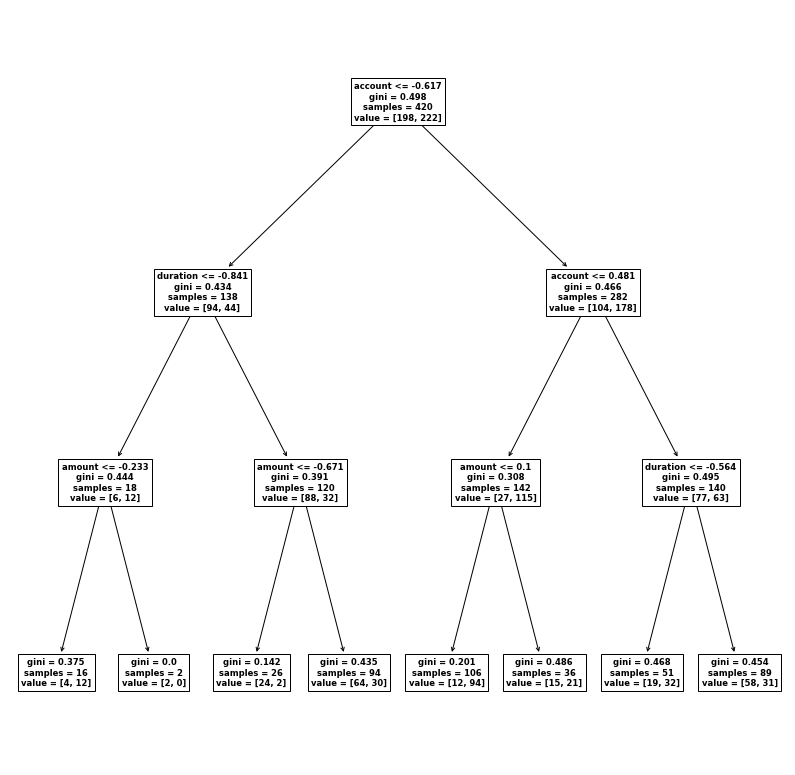

In [36]:
from sklearn.tree import plot_tree
from matplotlib import pylab as plt
%pylab inline

clf_dt = DecisionTreeClassifier(max_depth=3)
clf_dt.fit(X_train, y_train)

plt.figure(figsize=(14,14))
plot_tree(clf_dt, feature_names=X.columns)
plt.show()

# Композиции алгоритмов

Сегодня попробуем обучить композиции алгоритмов (случайный лес и градиентный бустинг) и сравним их качество с качеством более простых моделей, которые мы обучали в прошлый раз.

## Случайный лес

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10)
clf_rf.fit(X_train, y_train)

y_pred = clf_rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.6722222222222223

Подберём гиперпараметры метода.

In [54]:
params = {'n_estimators': [50, 100, 200, 300],
          'max_depth' : [2, 4, 6, 8, 10]}

gs = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

print(gs.best_estimator_)

RandomForestClassifier(max_depth=6, n_estimators=300)


Посмотрим на качество метода с найденными лучшими гиперпараметрами.

In [65]:
model = RandomForestClassifier(n_estimators=300, max_depth=6)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7

**Посмотрим на важности, которые случайный лес присвоил признакам. Тут важности - это аналоги весов в линейных моделях.**

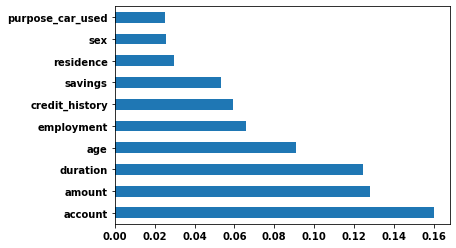

In [66]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

Посмотрим, как меняется качество предсказания случайного леса при увеличении числа деревьев в композиции.

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:18<00:00,  1.54it/s]


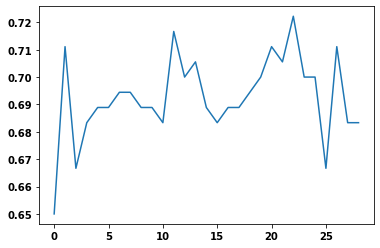

In [61]:
from tqdm import tqdm

acc = []

for n in tqdm(np.arange(10, 300, 10)):
    model = RandomForestClassifier(n_estimators=n, max_depth=6)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    acc.append(score)
    
plot(acc)

Мы видим, что при увеличении числа деревьев в лесе качество не начинает падать. То есть, **случайный лес не переобучается с ростом числа деревьев**.

## Градиентный бустинг

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=10)
clf_gb.fit(X_train, y_train)

y_pred = clf_gb.predict(X_test)

accuracy_score(y_test, y_pred)

0.6333333333333333

Подберём гиперпараметры метода.

In [51]:
params = {'n_estimators': [50, 100, 200, 300],
          'max_depth' : [2, 4, 6, 8, 10]}

gs = GridSearchCV(GradientBoostingClassifier(), params, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

print(gs.best_estimator_)

GradientBoostingClassifier(max_depth=2, n_estimators=50)


Посмотрим на качество метода с найденными лучшими гиперпараметрами.

In [68]:
model = GradientBoostingClassifier(n_estimators=50, max_depth=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.6888888888888889

Посмотрим на важность признаков по мнению градиентного бустинга.

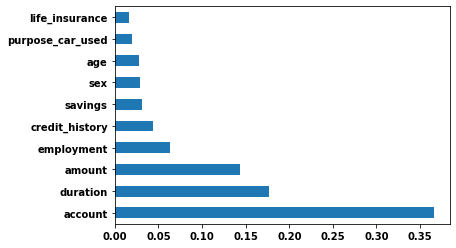

In [69]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

Как ведёт себя качество предсказания градиентного бустинга при увеличении числа деревьев в композиции?

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.51s/it]


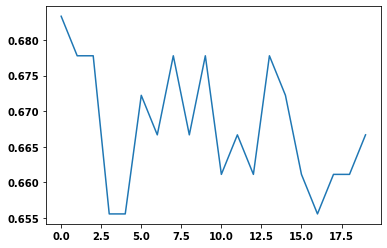

In [70]:
from tqdm import tqdm

acc = []

for n in tqdm(np.arange(10, 1000, 50)):
    model = GradientBoostingClassifier(n_estimators=n, max_depth=6)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    acc.append(score)
    
plot(acc)

Бустинг начинает переобучаться, начиная с некоторого числа деревьев в нём! 

## Метрики качества классификации

Метрика accuracy не учитывает тип ошибки. Проанализируем ошибки нашего алгоритма, используя другие метрики.

In [71]:
model = RandomForestClassifier(n_estimators=300, max_depth=6)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7

In [72]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

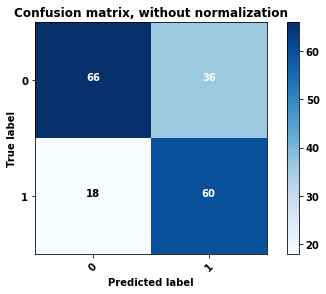

In [73]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['0','1'],
                        title='Confusion matrix, without normalization')

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('precision: ', precision_score(y_test, y_pred))
print('recall: ',    recall_score(y_test, y_pred))
print('f1-score: ',  f1_score(y_test, y_pred))

precision:  0.625
recall:  0.7692307692307693
f1-score:  0.6896551724137931
